In [24]:
%matplotlib inline

from numpy import sqrt, exp, cos, logical_and, where
from clawpack import riemann
from clawpack import pyclaw

# Riemann solver
def advection(q_l,q_r,aux_l,aux_r,problem_data):
    r"""
    1d linear advection riemann solver 
    """
    import numpy as np
    num_eqn = 1
    num_waves = 1

    # Convenience
    num_rp = q_l.shape[1]

    # Return values
    wave = np.empty( (num_eqn, num_waves, num_rp) )
    s = np.empty( (num_waves, num_rp) )
    amdq = np.empty( (num_eqn, num_rp) )
    apdq = np.empty( (num_eqn, num_rp) )

    # Local values
    delta = np.empty(np.shape(q_l))

    delta = q_r - q_l
    a =  problem_data['u']
    
    # Compute the wave
    # 1-Wave
    wave[0,0,:] = delta 
    s[0,:] = a

    # Compute the left going and right going fluctuations
    for m in range(num_eqn):
        amdq[m,:] = min(a,0) * wave[m,0,:]
        apdq[m,:] = max(a,0) * wave[m,0,:]

    return wave, s, amdq, apdq

# simulation setup
def setup(outdir='./_output',  output_style=1):
    
    solver    = pyclaw.ClawSolver1D(advection)
    solver.rp = riemann.advection_1D_py.advection_1D 
    solver.rp = advection
    solver.num_waves = 1
    solver.num_eqn   = 1
    solver.kernel_language = 'Python'
    solver.limiters    = pyclaw.limiters.tvd.superbee
    solver.bc_lower[0] = pyclaw.BC.extrap
    solver.bc_upper[0] = pyclaw.BC.extrap
    solver.order       = 2 #1: Godunov, 2: Lax-Wendroff-LeVeque
    
    x = pyclaw.Dimension(0.0, 2.0, 400, name='x')
    domain = pyclaw.Domain(x)
    num_eqn = 1
    
    state = pyclaw.State(domain, num_eqn)
    
    # Parameters
    a = 0.5  # advection velocity
    state.problem_data['u'] = a
    
    # Grid
    xc = domain.grid.x.centers
    beta = 100
    gamma = 0
    x0 = 0.75
    # initial condition
    state.q[0, :] = exp(-beta * (xc-x0)**2) + where(logical_and(xc > 0.1, xc < 0.4),  1, 0)
     
    claw          = pyclaw.Controller()
    claw.solution = pyclaw.Solution(state, domain)
    claw.solver   = solver
    claw.outdir   = outdir
    claw.tfinal   = 4.0
    claw.num_output_times = 40
    claw.keep_copy        = True
    claw.output_style     = output_style
    return claw


def setplot(plotdata):
    """ 
    Plot solution using VisClaw.
    """ 
    plotdata.clearfigures()  # clear any old figures,axes,items data

    plotfigure = plotdata.new_plotfigure(name='q', figno=1)

    # Set up for axes in this figure:
    plotaxes = plotfigure.new_plotaxes()
    plotaxes.ylimits = [-.2,1.0]
    plotaxes.title = 'q'

    # Set up for item on these axes:
    plotitem = plotaxes.new_plotitem(plot_type='1d_plot')
    plotitem.plot_var = 0
    plotitem.plotstyle = '-o'
    plotitem.color = 'b'
    plotitem.kwargs = {'linewidth':2,'markersize':5}
    
    return plotdata

def qtrue(x,t):
    """
    The true solution, for comparison.  
    """
    from numpy import mod, exp, where, logical_and
    beta = 100
    gamma = 0
    x0 = 0.75
    u = claw.solution.state.problem_data['u']  
    xm = x - u*t
    #xm = mod(xm, 1.)   # because of periodic boundary conditions
    q = exp(-beta * (xm-x0)**2) + where(logical_and(xm > 0.1, xm < 0.4),  1, 0)
    return q

In [25]:
claw = setup()
claw.run()


2024-02-09 16:26:46,353 INFO CLAW: Solution 0 computed for time t=0.000000
2024-02-09 16:26:46,361 INFO CLAW: Solution 1 computed for time t=0.100000
2024-02-09 16:26:46,367 INFO CLAW: Solution 2 computed for time t=0.200000
2024-02-09 16:26:46,374 INFO CLAW: Solution 3 computed for time t=0.300000
2024-02-09 16:26:46,379 INFO CLAW: Solution 4 computed for time t=0.400000
2024-02-09 16:26:46,385 INFO CLAW: Solution 5 computed for time t=0.500000
2024-02-09 16:26:46,390 INFO CLAW: Solution 6 computed for time t=0.600000
2024-02-09 16:26:46,395 INFO CLAW: Solution 7 computed for time t=0.700000
2024-02-09 16:26:46,401 INFO CLAW: Solution 8 computed for time t=0.800000
2024-02-09 16:26:46,407 INFO CLAW: Solution 9 computed for time t=0.900000
2024-02-09 16:26:46,414 INFO CLAW: Solution 10 computed for time t=1.000000
2024-02-09 16:26:46,429 INFO CLAW: Solution 11 computed for time t=1.100000
2024-02-09 16:26:46,438 INFO CLAW: Solution 12 computed for time t=1.200000
2024-02-09 16:26:46,44

{'cflmax': 0.9000000000000001,
 'dtmin': 0.009,
 'dtmax': 0.009000000000000001,
 'numsteps': 480}

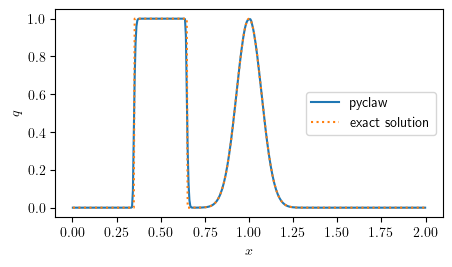

In [26]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
frame = claw.frames[5]
dt = claw.tfinal/claw.num_output_times
t = dt*5
x = frame.state.grid.c_centers
x = x[0]
true = qtrue(x,t)
fig, ax = plt.subplots(figsize=(5, 2.7))
w = frame.q[0,:]

ax.plot(x, w, label='pyclaw')
ax.plot(x, true, ':',label='exact solution')
ax.legend(loc='right')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$q$')
plt.savefig("frameAdvection5.pdf")

In [29]:
# Plotting the frames at different times
nsimul=np.size(claw.frames)
figs = []
for i in range(nsimul):
    fig = plt.figure(figsize=(5,3))
    frame = claw.frames[i]
    w = frame.q[0,:]
    x = frame.state.grid.c_centers
    x = x[0]
    dt = claw.tfinal/claw.num_output_times
    t = dt*i
    true = qtrue(x,t)
    plt.plot(x, w)
    plt.plot(x, true, '--',color = 'r')
    figs.append(fig)
    plt.close(fig)
    
from clawpack.visclaw import animation_tools
animation_tools.interact_animate_figs(figs)    

interactive(children=(IntSlider(value=0, description='frameno', max=40), Output()), _dom_classes=('widget-inte…

In [30]:
# Alternative to plot the frames
def q_true(t):
    import numpy
    # True Solution
    x_true = numpy.linspace(0, 2.0, 1000)
    q_true = qtrue(x_true,t)
    return q_true

def burgers_animation():
    import matplotlib.animation
    import numpy
    # compute the solution with the method define above:

    x = claw.frames[0].grid.dimensions[0].centers
    x_true = numpy.linspace(0., 2.0, 1000)
    
    fig = plt.figure()
    plt.rcParams['text.usetex'] = True


    axes = plt.subplot(1, 1, 1)
    axes.set_xlabel(r'$x$',fontsize = 14)
    axes.set_ylabel(r'$u(x, t)$',fontsize = 14)
    axes.set_xlim((x[0], x[-1]))
    axes.set_ylim((-0.1, 1.2))
    axes.set_title(" ")
    text = axes.text(1.0, 1.1, '')
    def init():
        axes.set_xlim((x[0], x[-1]))
        axes.set_ylim((-0.1,1.2))
        computed_line, = axes.plot(x[0], claw.frames[0].q[0, :][0], 'r')
        exact_line, = axes.plot(x_true[0], q_true(0.0)[0], 'k')
        return (computed_line, exact_line)
    
    computed_line, exact_line = init()
    
    def fplot(n):
        tt = claw.frames[n].t
        val = f'{tt:.2f}'
        text.set_text(r'$ t = {} $ s'.format(val))
        #computed_line.set_data([x,], [claw.frames[n].q[0, :]])
        exact_line.set_data([x_true], [q_true(claw.frames[n].t)])
        return (computed_line, exact_line)

    frames_to_plot = range(0, len(claw.frames))
    plt.close(fig)
    return matplotlib.animation.FuncAnimation(fig, fplot, frames=frames_to_plot, interval=100,
                                   blit=True, init_func=init, repeat=False)



In [31]:
from IPython.display import HTML 
anim = burgers_animation()
HTML(anim.to_jshtml())

2024-02-09 16:28:44,026 INFO CLAW: Animation.save using <class 'matplotlib.animation.HTMLWriter'>


In [17]:
# Exporting the frames
import os
from os.path import expanduser
# Finding the home and current directories
home = expanduser("~")
cwd = os.getcwd()
user_directory = cwd


mydir = 'advection_frames'
if not os.path.isdir(mydir): os.mkdir(user_directory+"/"+mydir)
 
    
anim.save(user_directory+'/'+mydir+'/AdvectionFrames.gif',writer="imagemagick",dpi=300,fps = 10)
anim.save(user_directory+'/'+mydir+'AdvectionLinéaire.mp4', fps=5,writer="ffmpeg",dpi=300)

2024-02-09 16:07:33,616 INFO CLAW: Animation.save using <class 'matplotlib.animation.ImageMagickWriter'>
2024-02-09 16:07:33,618 INFO CLAW: MovieWriter._run: running command: convert -size 1920x1440 -depth 8 -delay 10.0 -loop 0 rgba:- -layers OptimizePlus /home/ancey/dossier_Clawpack/ADVECTION/advection/AdvectionFrames.gif
2024-02-09 16:08:47,754 INFO CLAW: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-02-09 16:08:47,756 INFO CLAW: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1920x1440 -pix_fmt rgba -framerate 5 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y 'AdvectionLinéaire.mp4'


In [23]:
# Transform animation into images for latex
import subprocess
os.chdir(user_directory+'/'+mydir)
subprocess.run(["convert", "-coalesce", "AdvectionLinéaire.mp4", "Frame.png" ]) 
 

CompletedProcess(args=['convert', '-coalesce', 'AdvectionLinéaire.mp4', 'Frame.png'], returncode=0)